## An Investigation in classifying Alumni’s College Regions using respective Salaries

## 1. INTRODUCTION

**Classification Question: Given a person’s entry level and mid-career salary, which region did they most likely attend colleges in?**

In today’s society, education is becoming more and more important in order to make a good salary and to provide yourself with a nice stable life (OECD 2020). By answering our question, we are able to provide further insight on the trends between which school to pick and their average future salary which would aid students in their choice for which colleges to attend. The dataset we will use to answer this question is collected from The Wall Street Journal, derive the Payscale Inc. It contains a diverse array of colleges from across the United States, along with the average starting pay and mid-career salary for individuals who attended those colleges.
In our project, we aim to explore the potential correlation between a person’s starting median salary and mid-career median salary and the region of the college they attended using our data collected from The Wall Street Journal and Payscale Inc. The main question we seek to answer is: can we predict the region of a college based on an individual's average starting salary and mid-career salary?
To predict the region we will filter the dataset to include only the region, starting median salary, and the mid-career salary to ensure consistency and relevance, as well as expanding our predictors to percentile salary if necessary. By the end of the project we aim to develop accurate predictive models foyr college regions based on the median salaries of careers of different points. 

## 1.1 Method

To assess the question above, we'll start by determining the accuracy score of two models. First, a model with only starting median and mid-career salary; second, a model inaddition to the two initial predictors, also contains two percentile predictors, that is mid-career 25th and 75th percentile salary.

The metrics are that starting median salary and mid career salary (as well as the percentile salaries) are logical identifiers of alumni as people who graduated from the top colleges are likely to receive higher average salary at the start but for those who did not go to those colleges, they might start with lower average salary but eventually hit that bar.

We'll begin with a 5 neighbours classification by splitting the model into testing and training set, with the region being out factor. We'll then proceed to cross-validation with the higher accuracy model with a folding of 5. If both models yield similar accuracy, we will then perform tuning with both models and find the best k for each, then select the model with higher accuracy with respect to the k we find to perform the initial classification test. At then end, we'll use this result to generate a confusion matrix to assess our hypothesis in 1.2.2 and answer our classification question.

In [23]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


## 1.2 EXPLORATORY DATA ANALYSIS

In [24]:
download.file("https://raw.githubusercontent.com/colinyee9935/DSCI100_Group_Project/main/data/salaries_by_region.csv", "salary_region.csv")
salary_region<-read_csv("salary_region.csv")

salary_region <- salary_region |>
    rename_with(~str_to_lower(.) |>              #reformat the column names into lower case and replace space with underscores
                str_replace_all("[^[:alnum:]]+", "_"), .cols = everything())|>
    mutate(mid_career_10th_percentile_salary = na_if(mid_career_10th_percentile_salary, "N/A"))|>
    mutate(mid_career_90th_percentile_salary = na_if(mid_career_90th_percentile_salary, "N/A"))|>

#turning column to dbl
    mutate(mid_career_10th_percentile_salary_d=as.numeric(mid_career_10th_percentile_salary))|>
    mutate(mid_career_90th_percentile_salary_d=as.numeric(mid_career_90th_percentile_salary))|>
    select(-mid_career_10th_percentile_salary,-mid_career_90th_percentile_salary)|>

#rearranging columns
    select(1:4, mid_career_10th_percentile_salary_d, everything(), mid_career_90th_percentile_salary_d)|>
    rename(midc_10th_salary = mid_career_10th_percentile_salary_d,
          midc_25th_salary= mid_career_25th_percentile_salary,
          midc_75th_salary=mid_career_75th_percentile_salary,
          midc_90th_salary=mid_career_90th_percentile_salary_d)
    

#    select(school_name:mid_career_median_salary)
salary_region

Rows: 320 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): School Name, Region, Mid-Career 10th Percentile Salary, Mid-Career ...
dbl (4): Starting Median Salary, Mid-Career Median Salary, Mid-Career 25th P...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school_name,region,starting_median_salary,mid_career_median_salary,midc_10th_salary,midc_25th_salary,midc_75th_salary,midc_90th_salary
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Stanford University,California,70400,129000,68400,93100,184000,257000
California Institute of Technology (CIT),California,75500,123000,NA,104000,161000,NA
Harvey Mudd College,California,71800,122000,NA,96000,180000,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
State University of New York (SUNY) at Fredonia,Northeastern,37800,66200,32800,44200,93300,181000
University of Southern Maine,Northeastern,39400,63600,40400,47900,85700,117000
Mercy College,Northeastern,43700,62600,35600,47300,99000,134000


<p style="text-align:center;"><strong> Table 1.1: School Regions and Respective Salary Types  </strong></p>

## 1.2.1 Visualizations

Graphing of data sets: starting median salary and mid career median salary - distribution of the two definitive data we'll be using

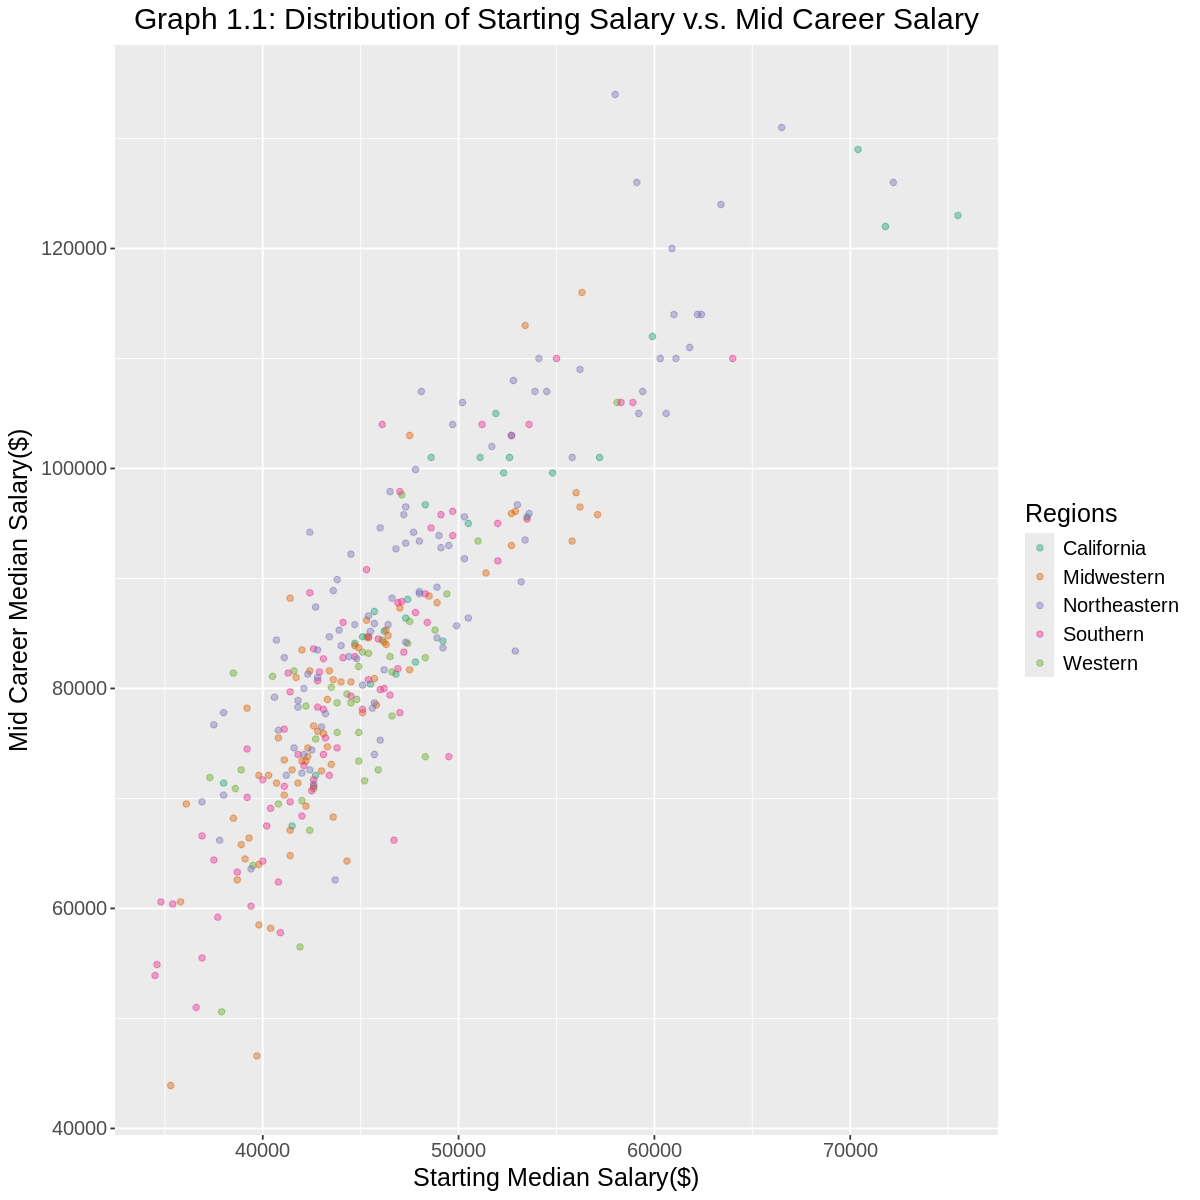

In [25]:


options(repr.plot.width = 10, repr.plot.height = 10)

salary_region_graph<-salary_region|>
    ggplot(aes(x=starting_median_salary, y=mid_career_median_salary, color=region))+
    geom_point(alpha = 0.4)+
    labs(x="Starting Median Salary($)",
        y="Mid Career Median Salary($)",
        title = "Graph 1.1: Distribution of Starting Salary v.s. Mid Career Salary",
        color="Regions")+
    scale_color_brewer(palette = "Dark2")+
    theme(text=element_text(size=15), plot.title = element_text(hjust = 0.5))

salary_region_graph



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


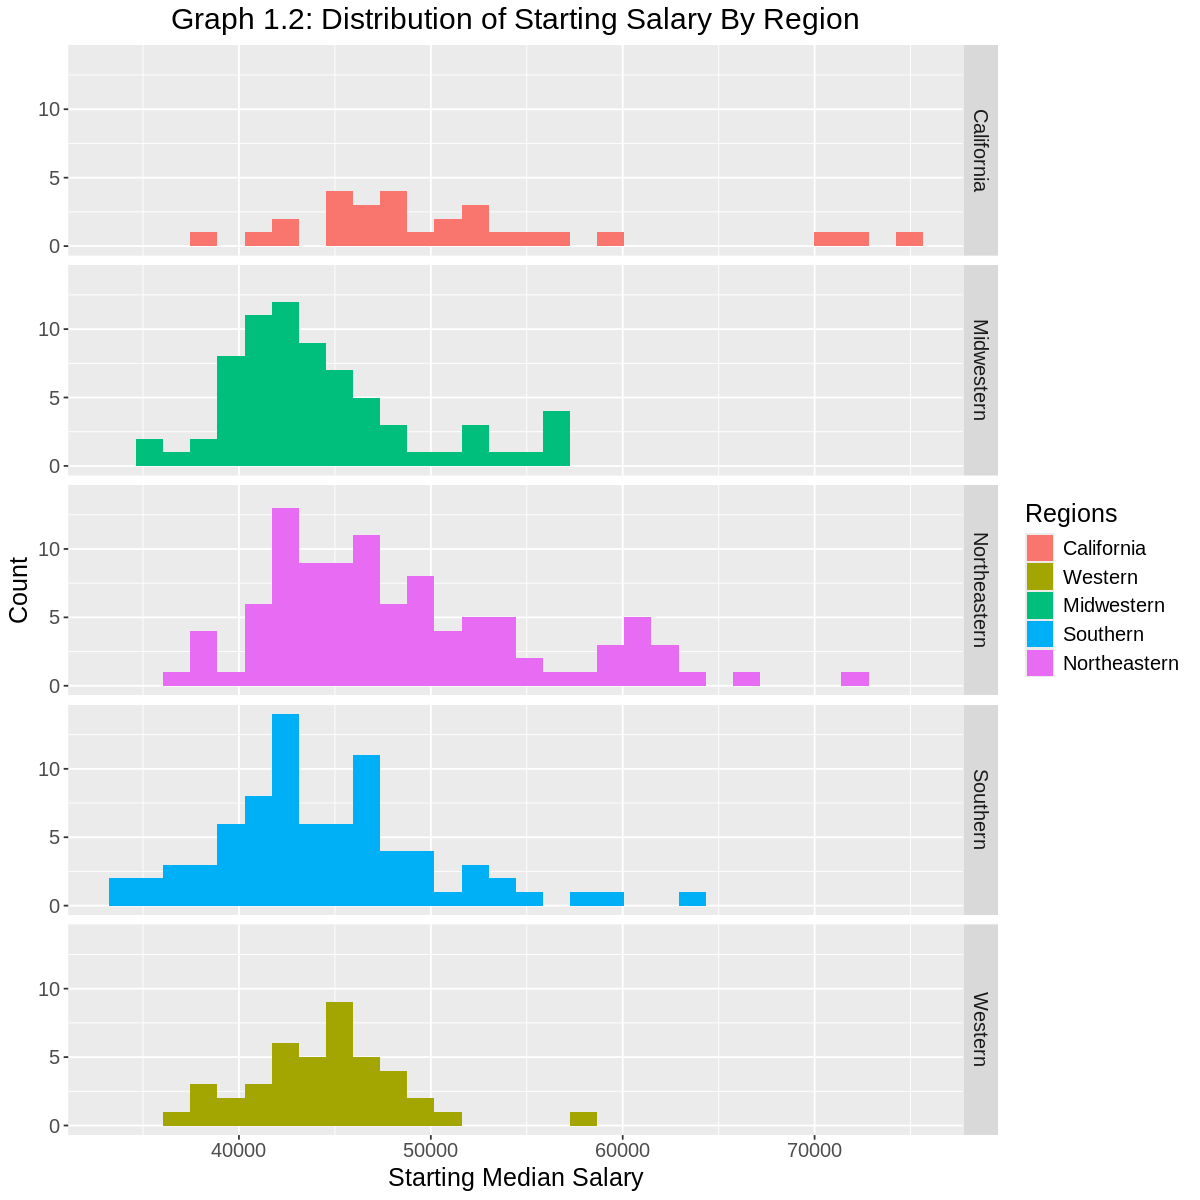

In [26]:
options(repr.plot.width = 10, repr.plot.height = 10)

region_hist <- ggplot(salary_region, aes(x = starting_median_salary, fill = as_factor(region))) +
    geom_histogram() +
    facet_grid(rows = vars(region))+
    labs(x="Starting Median Salary",
    y="Count",
    title = "Graph 1.2: Distribution of Starting Salary By Region",
    fill="Regions")+
    theme(text=element_text(size=15), plot.title = element_text(hjust = 0.5))

region_hist

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


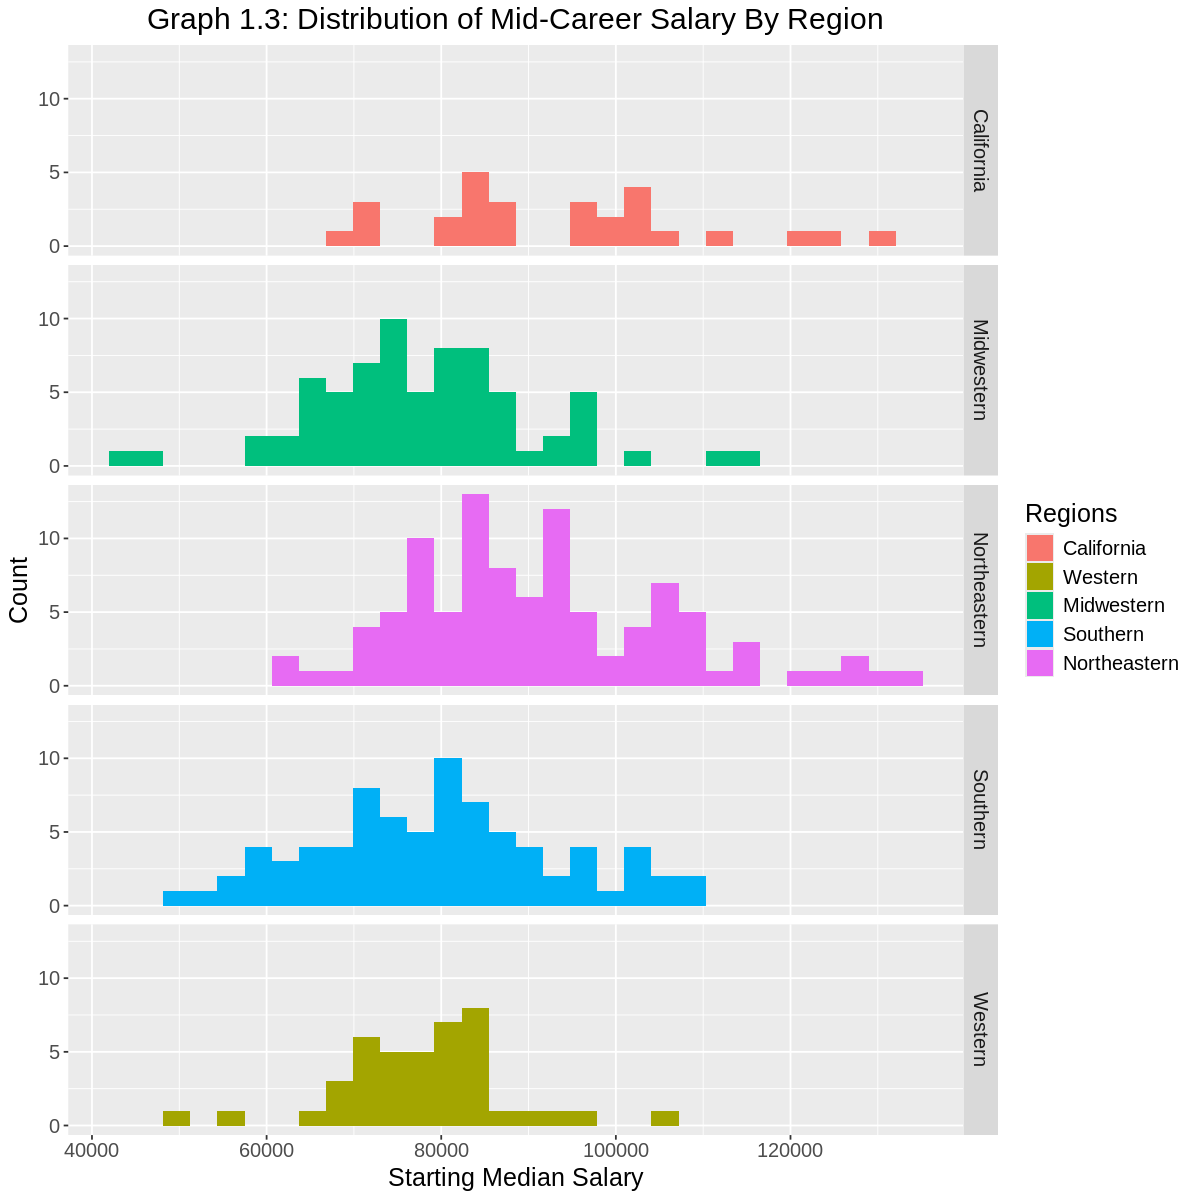

In [27]:
options(repr.plot.width = 10, repr.plot.height = 10)

region_hist <- ggplot(salary_region, aes(x = mid_career_median_salary, fill = as_factor(region))) +
    geom_histogram() +
    facet_grid(rows = vars(region))+
    labs(x="Starting Median Salary",
    y="Count",
    title = "Graph 1.3: Distribution of Mid-Career Salary By Region",
    fill="Regions")+
    theme(text=element_text(size=15), plot.title = element_text(hjust = 0.5))
region_hist

#### 1.2.2 Hypothesis:
From the two set of graphs above, we see regions California and Northeastern consistently have higher quartile of both type of salaries, while the other exhibits the opposite trend. Using this information, we hypothesize that our classification will be accurate on either ends of the salary range, and less accurate in the middle of the range. Overall, we predict that the overall accuracy of our model to be low considering the amount of mid-range salary data points are presented.

## 1.3 Tables

Investigate the number of observations in each region. This is important in finding whether each group has sufficient data points for reference

In [28]:
region_count<-salary_region|>
    group_by(region)|>
    summarize(count=n())
region_count

region,count
<chr>,<int>
California,28
Midwestern,71
Northeastern,100
Southern,79
Western,42


<p style="text-align:center;"><strong> Table 1.2: Regions Frequency </strong></p>

From the table below, we can see that there are an unbalance observation between regions

In [29]:
columns_to_check <- c("midc_10th_salary", "midc_25th_salary", "midc_75th_salary", "midc_90th_salary")

missing_counts <- salary_region |>
    summarize(across(all_of(columns_to_check), ~ sum(is.na(.), na.rm = TRUE)))
missing_counts

midc_10th_salary,midc_25th_salary,midc_75th_salary,midc_90th_salary
<int>,<int>,<int>,<int>
47,0,0,47


<p style="text-align:center;"><strong> Table 1.3: Missing Data Count for Percentile Columns </strong></p>

This is about 15% of the entire set with their respective columns.

# 2.Analysis

#### Converts the 'region' column to a factor.
In R, categorical outcomes used for classification must be factors to indicate that they represent discrete categories.
The 'region' is the outcome variable for your research question. We're predicting the college's region (categorical outcome) based on salaries.

In [30]:
# Convert 'region' from character to factor
salary_region$region <- as.factor(salary_region$region)

#### Splitting Dataset
Splits the dataset into a training set (75% of the data) and a testing set (25% of the data) for model training and calculating. To evaluate the model on unseen data and check its generalization ability. A common practice in machine learning to prevent overfitting. This step is foundational for developing and evaluating a predictive model based on our research question.

In [31]:
set.seed(100)

data_split <- initial_split(salary_region, prop = 0.75)
train_data <- training(data_split)
test_data <- testing(data_split)

#### Preparing the Model
Creates a recipe specifying how to preprocess the data, including scaling and centering the predictor variables. KNN relies on distance calculations. Scaling and centering make sure that each feature contributes equally to the distance computation.

In [32]:
set.seed(100)

recipe <- recipe(formula = region ~ starting_median_salary + mid_career_median_salary, data = train_data) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

#### Specifying and Fitting the KNN Model
Defines a KNN model with 5 neighbors and fits it to the training data. The choice of 5 neighbors is a starting point for the KNN algorithm, which can be adjusted based on model performance. The kknn engine is used for its efficiency and flexibility.

In [33]:
set.seed(100)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_fit <- workflow() %>%
  add_recipe(recipe) %>%
  add_model(knn_spec) %>%
  fit(data = train_data)

knn_spec
knn_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 5
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6875
Best kernel: rectangular
Best k: 5

#### Making Predictions and Evaluating the Model
Generates predictions for the test set and evaluates the model's performance using metrics like accuracy. To assess how well the model can predict the region based on salaries in unseen data. This step is crucial for understanding the model's effectiveness.

In [34]:
set.seed(100)

test_predictions <- predict(knn_fit, test_data) %>%
  bind_cols(select(test_data, c(school_name, region)))

test_results <- test_predictions %>%
  metrics(truth = region, estimate = .pred_class)

test_predictions

.pred_class,school_name,region
<fct>,<chr>,<fct>
Midwestern,Cal Poly San Luis Obispo,California
Northeastern,University of Southern California (USC),California
Southern,San Francisco State University (SFSU),California
⋮,⋮,⋮
Midwestern,Niagara University,Northeastern
Midwestern,State University of New York (SUNY) at Fredonia,Northeastern
Midwestern,University of Southern Maine,Northeastern


<p style="text-align:center;"><strong> Table 2.1: Prediction of Model with 2 Predictors </strong></p>

In [35]:
test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.3250000
kap,multiclass,0.1149355


<p style="text-align:center;"><strong> Table 2.2: Prediction Correctness of Model with 2 Predictors </strong></p>

#### Comments: Non-expanded Predictors
From the table above, our prediction model only yielded a horrendously low accuracy score of 0.325. Thus, let's try to proceed with incoporating more predictors as stated in the beginning of the project. We'll use mid 25th and mid 75th percentile salary as they do not contain missing data as indicated in the tables section, while the other two contain a significant number of missing data. We will create a new recipe object and a new fit using this new recipe, everything else remains the same.

In [36]:
set.seed(100)

recipe_percentile <- recipe(region ~ starting_median_salary + mid_career_median_salary + midc_25th_salary + midc_75th_salary, data = train_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit_percentile <- workflow() |>
  add_recipe(recipe_percentile) |>
  add_model(knn_spec) |>
  fit(data = train_data)

test_percentile <- predict(knn_fit_percentile, test_data) |>
  bind_cols(select(test_data, c(school_name, region)))

percentile_results_e <- test_predictions |>
  metrics(truth = region, estimate = .pred_class)

test_percentile

.pred_class,school_name,region
<fct>,<chr>,<fct>
Midwestern,Cal Poly San Luis Obispo,California
California,University of Southern California (USC),California
Midwestern,San Francisco State University (SFSU),California
⋮,⋮,⋮
Western,Niagara University,Northeastern
Midwestern,State University of New York (SUNY) at Fredonia,Northeastern
Midwestern,University of Southern Maine,Northeastern


<p style="text-align:center;"><strong> Table 2.3: Prediction of Model with 4 Predictors </strong></p>

In [37]:
percentile_results_e

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.3250000
kap,multiclass,0.1149355


<p style="text-align:center;"><strong> Table 2.4: Prediction Correctness of Model with 4 Predictors </strong></p>

#### Comments: Expanded Predictors
From the table, we can see that the accuracy score did not change, but the .pred_class reflects changes in the prediction. Thus, further investigation is needed with different k-values through tuning. Let's proceed with this idea using a standard fold of 5, we'll duplicate this process with both the expanded predictors recipe and the original recipe. After we locate the best number of k-nearest neighbour and the model to use, we'll validate our finding with our hypothesis using a confusion matrix. 

# 3.Performing Cross Validation on Both Sets

In this section, we perform a cross validation to test for the internal consistency of our model using vfold_cv. This is an important step as it iterates the process of training and testing by breaking the data frame into subsets according to the desired times given. In this case, we'll use the stardard v=5.

#### 3.1 Unexpanded Predictors Model

In [38]:
set.seed(100)

region_vfold <- vfold_cv(train_data, v = 5, strata = region)

region_resample_fit <- workflow() |>
       add_recipe(recipe) |>
       add_model(knn_spec) |>
       fit_resamples(resamples = region_vfold)

region_metrics<- region_resample_fit|>
  collect_metrics()
region_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,multiclass,0.3625142,5,0.02128744,Preprocessor1_Model1
roc_auc,hand_till,0.6251807,5,0.03190363,Preprocessor1_Model1


<p style="text-align:center;"><strong> Table 3.1: Prediction Correctness of Model with 2 Predictors By 5 Folding  </strong></p>

#### 3.2 Expanded Predictors Model

In [39]:
percentile_resample_fit <- workflow() |>
       add_recipe(recipe_percentile) |>
       add_model(knn_spec) |>
       fit_resamples(resamples = region_vfold)

percentile_metrics<- percentile_resample_fit|>
  collect_metrics()
percentile_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,multiclass,0.2875496,5,0.02935745,Preprocessor1_Model1
roc_auc,hand_till,0.6159274,5,0.01383806,Preprocessor1_Model1


<p style="text-align:center;"><strong> Table 3.2: Prediction Correctness of Model with 4 Predictors By 5 Folding </strong></p>

#### 3.3 Comment 3:
From the metrics collected from 3.1 and 3.2, we can see that the mean accuracy of the original unexpanded model seems to be a bit better than the expanded predictors model and the roc_auc, which measures   how much the model is capable of distinguishing between classes at various threshold setting is significantly lower. This is likely due to the incorporation of more predictors, for which these percentile salaries do not have a predictable patter in real life. We'll dig deeper into both models through tuning.

# 4.Tuning the Model

In this section, we'll use the K-nearest neighbour classification, but instead we'll set neighbors to tune in the spec for finding the best K number. Tune allows each parameter in the model t0 be adjusted rather than given a specific value. We'll set a tiblle for the deserible K number we are looking at, from 1 to 10. This is performed for both models, graphs are created then using the results yielded.

#### 4.1 Unexpanded Predictors Model

In [40]:
set.seed(100)
knn_tune <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

gridvals<-tibble(neighbors=seq(from=1, to=10, by=1))

knn_results <- workflow() |>
       add_recipe(recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = region_vfold, grid = gridvals) |>
       collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.2839929,5,0.03677792,Preprocessor1_Model01
1,roc_auc,hand_till,0.5515164,5,0.03929124,Preprocessor1_Model01
2,accuracy,multiclass,0.2839929,5,0.03677792,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,hand_till,0.6309468,5,0.01667540,Preprocessor1_Model09
10,accuracy,multiclass,0.3078830,5,0.02942722,Preprocessor1_Model10
10,roc_auc,hand_till,0.6369042,5,0.01365612,Preprocessor1_Model10


<p style="text-align:center;"><strong> Table 4.1: Prediction Correctness of Model with 2 Predictors by Varying Neighbours  </strong></p>

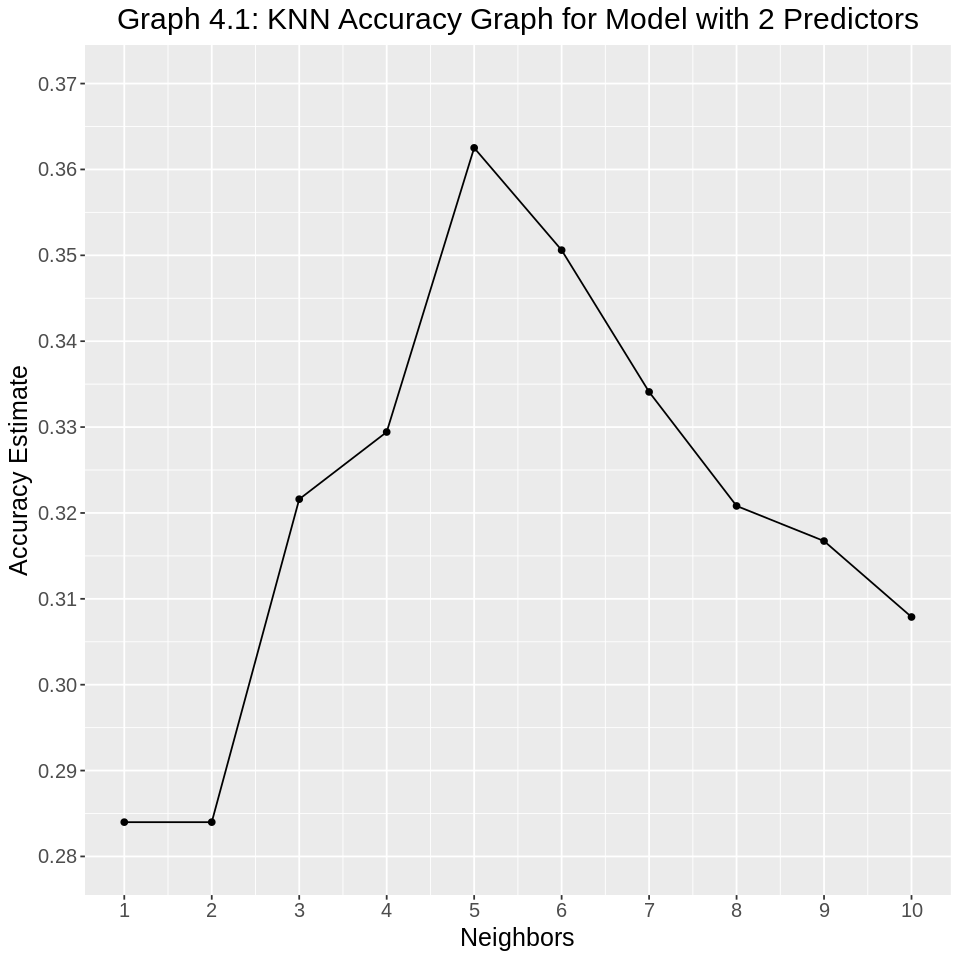

In [41]:
set.seed(100)
options(repr.plot.height = 8, repr.plot.width = 8)

accuracies <- knn_results |> 
       filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate",
    title="Graph 4.1: KNN Accuracy Graph for Model with 2 Predictors")+
    theme(text=element_text(size=15), plot.title = element_text(hjust = 0.5))+
    scale_x_continuous(breaks = 1:10)+
    scale_y_continuous(breaks = seq(0.28, 0.40, by = 0.01),limits = c(0.28, 0.37)) #added for better comparison
cross_val_plot

#### 4.2 Expanded Predictors Model

In [42]:
set.seed(100)
percentile_results <- workflow() |>
       add_recipe(recipe_percentile) |>
       add_model(knn_tune) |>
       tune_grid(resamples = region_vfold, grid = gridvals) |>
       collect_metrics()
percentile_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.2998156,5,0.02186814,Preprocessor1_Model01
1,roc_auc,hand_till,0.5829963,5,0.00963606,Preprocessor1_Model01
2,accuracy,multiclass,0.2998156,5,0.02186814,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,hand_till,0.6106809,5,0.01546389,Preprocessor1_Model09
10,accuracy,multiclass,0.2959823,5,0.02742283,Preprocessor1_Model10
10,roc_auc,hand_till,0.6195873,5,0.01761023,Preprocessor1_Model10


<p style="text-align:center;"><strong> Table 4.2: Prediction Correctness of Model with 4 Predictors by Varying Neighbours </strong></p>

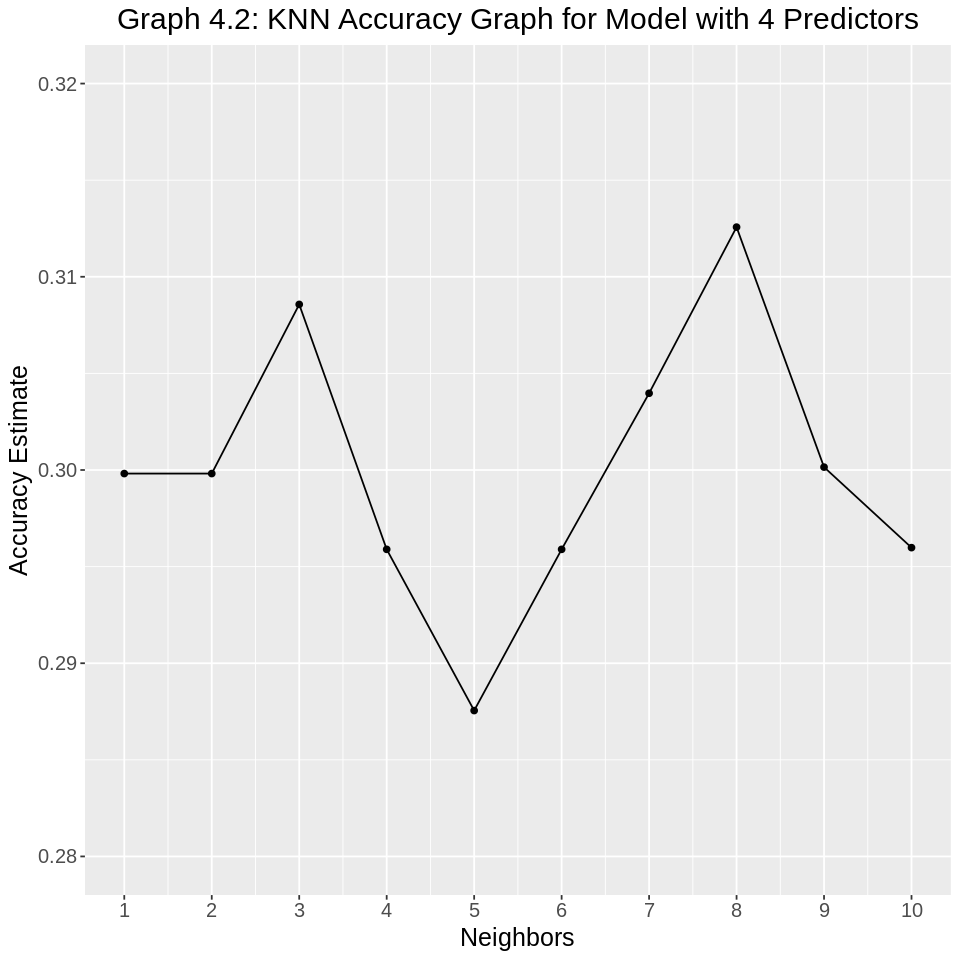

In [43]:
set.seed(100)
options(repr.plot.height = 8, repr.plot.width = 8)

percentile_accuracies <- percentile_results |> 
       filter(.metric == "accuracy")

percentile_val_plot <- ggplot(percentile_accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate",
    title="Graph 4.2: KNN Accuracy Graph for Model with 4 Predictors")+
    theme(text=element_text(size=15), plot.title = element_text(hjust = 0.5))+
    scale_x_continuous(breaks = 1:10)+
    scale_y_continuous(breaks = seq(0.28, 0.32, by = 0.01),limits = c(0.28, 0.32)) #adjusted for comparison
percentile_val_plot

#### 4.3 Comments:
From the two graphs above, we can see that the accuracy estimate peaks at 5 for the unexpanded predictors model, while for the expanded predictors model, it peaks at 8. This is likely due to the added randomness of in the percentile predictors as the percentile wages are not bonded by a specific order of increment in real-life setting, which is also explanatory through the zigzag shape in the KNN Accuracy Graph for Expanded Model. From the graph we can see that the unexpanded model has a slightly higher accuracy (5% but still pretty low) than the expanded model, and the shape of the accuracy curves are also presented in better shape comparing the expanded model, which is indicative of it's potential consistency and stability when predicting different sets (despite it's low accuracy). Thus, taking into account the consistency and stability of the model, we'll proceed with the unexpanded model to test our hypothesis.

# 5. Hypothesis Testing
Since we have N=5 as the highest accuracy neighbours with the unexpanded model in this setting, we can use the result from section 2. We can use conf_mat, this will show us a table comparing the predicted labels with the true labels.

In [44]:
pre_mat <- test_predictions |> 
       conf_mat(truth = region, estimate = .pred_class)
pre_mat

              Truth
Prediction     California Midwestern Northeastern Southern Western
  California            0          0            0        1       0
  Midwestern            3          6            6        5       2
  Northeastern          2          6           12        3       3
  Southern              1          7            2        6       4
  Western               2          0            2        5       2

<p style="text-align:center;"><strong> Table 5.1: Confusion Matrix for Model with 2 Predictors with N=5 </strong></p>

To verify our hypothesis from Table 5.1, we can set each region as the "positive" class and find the precision for each class. In this scenario, we have:

 - California: 0
 - Midwestern: 0.3157
 - Northeastern: 0.5454
 - Southern: 0.3158
 - Western: 0.18

If we omit california due to it's insignificant size, then we would find the precision for the rest to be somewhat comfirming our hypothesis. The Northeastern region has the highest precision as it's easier to predict due to the fact it has many high paying jobs (outliers) that deviate from the cluster of which the rest of the regions are in. And as it gets to mid to low range of salary, we can see the midwestern and southern has relative similar precision rate, which can be reflected by the similar distribution in Graph 1.2 and 1.3. Then we have western with the lowest accuracy potentially due to the dissimilar shape of it's distribution which matches with the other three regions when it comes to mid-career salary. Thus, we reach to the conclusion that our model likely validifies our hypothesis above.

# 6. Discussion

### Summary
From our analysis, we find that predicting the alumni's graduating area using their starting and medium salaries are low in accuracy (only around 0.3-0.4). In almost 70% cases, our model failed to classified the alumni into the correct graduation area. This pattern of identification as discussed in the introduction only becomes obvious when it comes to area with significantly high paying, such Northeastern, but the precision is still as low as 54%. Thus, while the analysis validated our hypothesis about the model, it fails our research goal as above as we can not effectively categorized the alumni's regions based on their salaries.

### Expected Outcomes
At the beginning, from Graph 1.2 and 1.3, We could find that some regions have a higher starting salary than other regions, so we can generalize and assume that a higher starting salary/middle salary would correlate to those specific regions. Nonetheless, from the analysis above, specifically Table 4.1 and 4.2, we can see that the accuracy of the model is concerning. This is likely due to the indefinite clusture of datapoints between starting salary and mid-carrear salary. In other words, relationship between region and salary only becomes obvious when we goes to either end of the bell curve/distribution as described in section 5, that is, certain regions have significantly more paying or less jobs than the other regions. These patterns are only identifiable in these limited number of regions, but the rest of the areas, which account for bigger portion of the population, are all blended together as we can see from our initial scatterplor Graph 1.1, making it almost impossible to differentiate between alumni graduating from different regions that have relatively the same paying.

### Impact of findings
The impact of findings means it's not possible for us to draw a clear relationship between graduation area and the alumni's salaries in majority of the cases in the U.S.. Thus, it's hard to infer further problems this entails, such as the imbalance allocation of educational resources. It may also means that the economic structure of the country is relative balanced and the wealth gap is low, as the general population are being paid mid-range salary.

### Future question
Future research could explore the relationship of graduation area of alumni's salaries in other countries with more distinct economic structure and wealth gap such as countries in Africa (Musau 2017), to first, validify whether the finding in this project is universal and second, if not, then it's indicative of clear wealth gap and imbalance educational resources, which then can be addressed accordingly by using the findings as a starting point. 


## Biliography

OECD. “What Are the Earnings Advantages from Educations?” StatLink, 2020.

Wall Street Journal. “WSJ.com.” Www.wsj.com, 2017, www.wsj.com/public/resources/documents/info-Salaries_for_Colleges_by_Type-sort.html.

Musau, Zipporah. “Africa Grapples with Huge  Disparities in Education | Africa Renewal.” Un.org, Africa Renewal, Dec. 2017, www.un.org/africarenewal/magazine/december-2017-march-2018/africa-grapples-huge-disparities-education.